# Multiple Approaches to Implementing Interrupts

## Method 1: Runtime Interrupts Using interrupt() Function

### Step 1: Import Required Libraries

In [2]:
from typing import TypedDict
import uuid
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command

### Step 2: Define the State Schema

In [3]:
class State(TypedDict):
    some_text: str

### Step 3: Create the Human Node Function

In [4]:
def human_node(state: State):
    print(f"Node started with state: {state}")
    # Present current state to human and pause execution
    value = interrupt({
        "text_to_revise": state["some_text"]
    })
    print(f"Received human input: {value}")
    # When resumed, this will contain the human's input
    return {
        "some_text": value
    }

### Step 4: Build the Graph Structure

In [5]:

# Build the graph
graph_builder = StateGraph(State)
graph_builder.add_node("human_node", human_node)
graph_builder.add_edge(START, "human_node")

checkpointer = InMemorySaver() 
graph = graph_builder.compile(checkpointer=checkpointer)


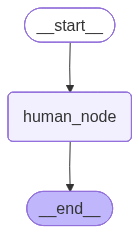

In [6]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Step 7: Initialize Execution

In [7]:
# Execute with thread ID
config = {"configurable": {"thread_id": uuid.uuid4()}}

result = graph.invoke({"some_text": "original text"}, config=config)

Node started with state: {'some_text': 'original text'}


In [8]:
print("Graph paused! Here's what happened:")
print(f"Current state: {result}")
print(f"Interrupt details: {result.get('__interrupt__')}")

Graph paused! Here's what happened:
Current state: {'some_text': 'original text', '__interrupt__': [Interrupt(value={'text_to_revise': 'original text'}, resumable=True, ns=['human_node:c7f17c3e-a818-8fb5-2785-b5189d3c1e5d'])]}
Interrupt details: [Interrupt(value={'text_to_revise': 'original text'}, resumable=True, ns=['human_node:c7f17c3e-a818-8fb5-2785-b5189d3c1e5d'])]


In [9]:
# Check the current state
current_state = graph.get_state(config)
print(f"📊 Current graph state: {current_state.values}")
print(f"Next node to execute: {current_state.next}")


📊 Current graph state: {'some_text': 'original text'}
Next node to execute: ('human_node',)


In [11]:
# result will contain '__interrupt__' with the interrupt information
interrupt_data = result.get('__interrupt__')[0].value
interrupt_data
# interrupt_data will be: {"text_to_revise": "original text"}

{'text_to_revise': 'original text'}

In [12]:
print("\n Resuming with human input...")
final_result = graph.invoke(Command(resume="Edited text"), config=config)
print(f" Final result: {final_result}")


 Resuming with human input...
Node started with state: {'some_text': 'original text'}
Received human input: Edited text
 Final result: {'some_text': 'Edited text'}


## Method 2: Compile-Time Interrupts Using interrupt_before and interrupt_after

### interrupt_before


In [13]:
from typing import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command
import uuid

class SimpleState(TypedDict):
    message: str
    processed: bool

def processing_node(state: SimpleState):
    print(f"Processing node received: {state}")
    return {
        "message": f"Processed: {state['message']}",
        "processed": True
    }

def final_node(state: SimpleState):
    print(f"Final node received: {state}")
    return {
        "message": f"Final: {state['message']}",
        "processed": True
    }

# Build graph
graph_builder = StateGraph(SimpleState)
graph_builder.add_node("processing_node", processing_node)
graph_builder.add_node("final_node", final_node)
graph_builder.add_edge(START, "processing_node")
graph_builder.add_edge("processing_node", "final_node")


In [19]:
# Example 1: interrupt_before
print("=== Testing interrupt_before ===")
graph_before = graph_builder.compile(
    checkpointer=InMemorySaver(),
    interrupt_before=["processing_node"]
)

=== Testing interrupt_before ===


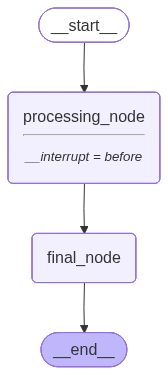

In [20]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph_before.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [31]:

config = {"configurable": {"thread_id": str(uuid.uuid4())}}

# Starting execution
result = graph_before.invoke({"message": "Hello", "processed": False}, config=config)
print(result)

{'message': 'Hello', 'processed': False}


In [32]:
state = graph_before.get_state(config)
print(f"Graph state: {state.values}")
print(f"Next node: {state.next}")

Graph state: {'message': 'Hello', 'processed': False}
Next node: ('processing_node',)


In [33]:
# Method 1: Pass None as input to resume from checkpoint
final_result = graph_before.invoke(None, config=config)
print(f"Final result: {final_result}")

Processing node received: {'message': 'Hello', 'processed': False}
Final node received: {'message': 'Processed: Hello', 'processed': True}
Final result: {'message': 'Final: Processed: Hello', 'processed': True}


### interrupt_after


In [34]:
from typing import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command
import uuid

class SimpleState(TypedDict):
    message: str
    processed: bool

def processing_node(state: SimpleState):
    print(f"Processing node received: {state}")
    return {
        "message": f"Processed: {state['message']}",
        "processed": True
    }

def final_node(state: SimpleState):
    print(f"Final node received: {state}")
    return {
        "message": f"Final: {state['message']}",
        "processed": True
    }

# Build graph
graph_builder = StateGraph(SimpleState)
graph_builder.add_node("processing_node", processing_node)
graph_builder.add_node("final_node", final_node)
graph_builder.add_edge(START, "processing_node")
graph_builder.add_edge("processing_node", "final_node")


In [35]:
### Testing interrupt_after 
graph_after = graph_builder.compile(
    checkpointer=InMemorySaver(),
    interrupt_after=["processing_node"]
)

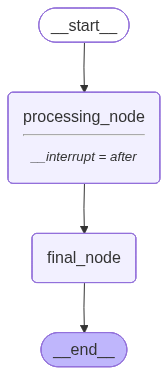

In [36]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph_after.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [37]:
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
# print(" Starting execution with stream...")

# Initial execution
for chunk in graph_after.stream({"message": "Stream test", "processed": False}, config=config):
    print(f"Chunk: {chunk}")

Processing node received: {'message': 'Stream test', 'processed': False}
Chunk: {'processing_node': {'message': 'Processed: Stream test', 'processed': True}}
Chunk: {'__interrupt__': ()}


In [38]:
state = graph_after.get_state(config)
print(f"Graph state: {state.values}")
print(f"Next node: {state.next}")

Graph state: {'message': 'Processed: Stream test', 'processed': True}
Next node: ('final_node',)


In [39]:
print("\n Resuming with stream...")
# Resume execution
for chunk in graph_after.stream(None, config=config):
    print(f"Resume chunk: {chunk}")


 Resuming with stream...
Final node received: {'message': 'Processed: Stream test', 'processed': True}
Resume chunk: {'final_node': {'message': 'Final: Processed: Stream test', 'processed': True}}


## Resume Lifecycle

In [43]:
import uuid
from typing import TypedDict
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START
from langgraph.types import interrupt, Command


def demo_resume_lifecycle():
    class SimpleState(TypedDict):
        counter: int
        message: str
    
    def counting_node(state: SimpleState):
        print(f"Node execution started - Counter: {state['counter']}")
        
        # Simulate some work before interrupt
        new_counter = state['counter'] + 1
        print(f"Incremented counter to: {new_counter}")
        
        # Interrupt and ask for human input
        human_input = interrupt({
            "current_counter": new_counter,
            "prompt": "What message should I add?"
        })

        # human_input = interrupt({
        # "text_to_revise": "Some Text"
        # })
        
        print(f" Received human input: {human_input}")
        
        return {
            "counter": new_counter,
            "message": human_input
        }
    
    # Build and compile graph
    graph_builder = StateGraph(SimpleState)
    graph_builder.add_node("counting_node", counting_node)
    graph_builder.add_edge(START, "counting_node")
    
    graph = graph_builder.compile(checkpointer=InMemorySaver())
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    
    print("=== Initial Execution ===")
    result = graph.invoke({"counter": 0, "message": ""}, config=config)
    
    print(f"Graph paused with state: {result}")
    print(f"Interrupt data: {result.get('__interrupt__')[0].value}")
    
    print("\n=== Resume Execution ===")
    final_result = graph.invoke(Command(resume="Hello from human!"), config=config)
    print(f"Final state: {final_result}")

# Run the demo
demo_resume_lifecycle()

=== Initial Execution ===
Node execution started - Counter: 0
Incremented counter to: 1
Graph paused with state: {'counter': 0, 'message': '', '__interrupt__': [Interrupt(value={'current_counter': 1, 'prompt': 'What message should I add?'}, resumable=True, ns=['counting_node:80cae11d-d01e-4901-f606-8004e328d65f'])]}
Interrupt data: {'current_counter': 1, 'prompt': 'What message should I add?'}

=== Resume Execution ===
Node execution started - Counter: 0
Incremented counter to: 1
 Received human input: Hello from human!
Final state: {'counter': 1, 'message': 'Hello from human!'}
